In [1]:
## packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Practical session 5: missing data, scaling and dimensionality reduction

<div class="alert alert-block alert-info">
    <h2>Table of Contents </h2><a class="anchor" id="top"></a>
    <br><a href="#section_1"> Missing data</a>
    <br><a href="#intermezzo">Intermezzo - Scaling </a>
    <br><a href="#section_2"> Dimensionality reduction </a>
    <br><a href="#Optional">  Optional - Clustering</a>
</div>

<div class="alert alert-block alert-info"> 
 In this practical we will cover how to handle missing data, normalization and dimensionality reduction. At the end of a practical there is an optional part about cluster analysis for those interested. Clustering algorithms are present in scikit-learn very similarly as classification or regression algorithms. So you should be able to solve this on your own quite easily. 
 
 
 Last theory lecture also included hyperparameter optimization, but you already saw that during the practical class of Week 3.
</div>

<h2 style="display: inline"> Missing data </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a> 

<div class="alert alert-block alert-warning">
For reproducibility purposes we will always use random_state=0 in this practical. Don't forget to assign this parameter in your functions if it is needed.
</div>

For this part of the practical we will work with the *communities* dataset, which has a large number of features, as well as misisng values. it contains demographic information about countries in the United states, and the goal is to predict the number of violent crimes (attribute A122).

In [5]:
# We load the dataset and extract the feature we want to predict
data_dir = "/data/gent/shared/000/gvo00070/BigDataScience2023/"
df = pd.read_csv(data_dir + 'communities.psv', sep = '|', na_values = '?')
X = df.drop("A122", axis=1)
y = df["A122"]

<div class="alert alert-success">
<h3> Exercise:</h3>
<ol> 
 <li>Divide the dataset into a training (80%) and test (20%) set
 <li>For the training set, count the number of attributes with missing values as well as the percentage of missing values
</ol> 

**HINT**: look at how the missing values are represented in the data (their datatype)
</div>

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
attributes_with_missing = np.sum(np.any(np.isnan(X_train), axis=0))
print("Attributes with missing values:", attributes_with_missing)

Attributes with missing values: 23


In [11]:
missing_rate = np.count_nonzero(np.isnan(X_train))/np.prod(X_train.shape)
print("Percentage of missing values:", missing_rate*100)

Percentage of missing values: 15.161621871627526


<div class="alert alert-success">
<h3> Exercise:</h3>
There are multiple single imputation strategies for missing data implemented in scikit-learn. Perform the following strategies:
<ol> 
 <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">Simple imputation</a> with the mean
 <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">Simple imputation</a> with the median
 <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer">Nearest Neighbor imputation</a> 
</ol> 
For each strategy fit a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">linear regression model </a>and evaluate the model's performance with the R-squared metric.

Each of these methods has a parameter <i>add_indicator</i>. Find out what this does and evaluate it's influence on the prediction performance of this task.
</div>

The *add_indicator* parameters allows to use informtion about which values are missing as an extra feature. For a single array this would mean that the algorithm would add a column to the data that indicates missingness of a data point in the non-transformed data.

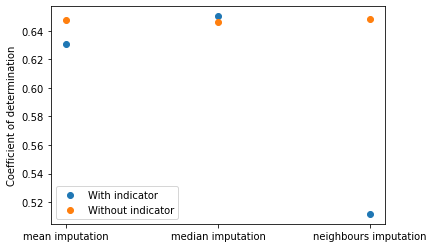

In [34]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression

# Declare the imputation methods
imputation_methods_no_ind = {
    'mean imputation': SimpleImputer(strategy="mean", add_indicator=False),
    'median imputation': SimpleImputer(strategy="median", add_indicator=False),
    'neighbours imputation': KNNImputer( add_indicator=False),
}
imputation_methods_ind = {
    'mean imputation': SimpleImputer(strategy="mean", add_indicator=True),
    'median imputation': SimpleImputer(strategy="median", add_indicator=True),
    'neighbours imputation': KNNImputer( add_indicator=True),
}

# Declare the model
clf = LinearRegression()

# Run the imputators + models
## Without inidicators
scores_no_ind = np.zeros(3)
methods = []
i = 0
for method, imputer in imputation_methods_no_ind.items():
    imputer.fit(X_train)
    X_train_imp = imputer.transform(X_train)
    X_test_imp = imputer.transform(X_test)
    
    clf.fit(X_train_imp, y_train)
    scores_no_ind[i] = clf.score(X_test_imp, y_test)
    methods.append(method)
    i += 1
    
add_indicator = True

## With indicators
scores_ind = np.zeros(3)
i = 0
for method, imputer in imputation_methods_ind.items():
    imputer.fit(X_train)
    X_train_imp = imputer.transform(X_train)
    X_test_imp = imputer.transform(X_test)
    
    clf.fit(X_train_imp, y_train)
    scores_ind[i] = clf.score(X_test_imp, y_test)
    i += 1

# Plot results
fig, ax = plt.subplots()
ax.scatter(methods, scores_ind,  label = 'With indicator' )
ax.scatter(methods, scores_no_ind,  label = 'Without indicator' )
ax.legend()
plt.ylabel('Coefficient of determination')
plt.show()

<h2 style="display: inline"> Intermezzo - scaling </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="intermezzo"></a> 

As mentioned in the lectures, scaling and normalization is oftentimes quite important as it can heavily influence prediction results. Therefore,  **it is almost always recommended to perform some form of normalization or scaling**, especially with regularization, distance-based classifiers and classifiers with normality/distribution assumptions. In scikit-learn you have the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler">RobustScaler</a> available for respectively standardizaton and robust feature scaling. 

But do note, that in order to prevent data leakage, **scaling can only be based on the training dataset characteristics**. As the model is trained on scaled features, for a proper prediction the test data will also need to be on the same scale. But the test data can only be scaled based on the training data's characteristics, not on its own characteristics. *E.g. for standardization, the mean and variance of the training data will be calculated and used for transformation of the entire dataset.*

Worthwhile to mention here is also the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html"> pipeline constructor </a> in scikit-learn. This constructor allows you to sequentially perform multiple scikit-learn transform actions and one final estimation action.

So for instance say you would want to perform a scaling transformation and then fit a linear SVM model, with the help of the pipeline constructor this can be efficiently implemented:

In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

# Construct a toy classification dataset
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# Construct a pipeline with a scaler and a svc step
# This pipeline can be used as any other constructor
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])  

pipe.fit(X_train, y_train)

# The pipeline will inherit the scoring method from the final estimator
# Scaling will only be trained on the train dataset, but the test data will also be transformed
pipe.score(X_test, y_test) 

0.88

In [38]:
# You can access the independent steps
pipe['scaler'].mean_

array([-0.11573584, -0.09293973,  0.02018342, -0.09238542, -0.13040859,
        0.16463763, -0.12202019, -0.02483696, -0.05495534, -0.03486058,
       -0.0366951 , -0.03897222, -0.14321947, -0.0654956 , -0.05421968,
        0.04105662,  0.2041835 , -0.08359841,  0.16394695, -0.03460228])

<h2 style="display: inline"> Dimensionality reduction </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a> 

Dimensionality reduction is an important tool in data science, it performs a transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data. These properties vary with each algorithm.

**Principal component analysis (PCA)** might be the most known dimensionality reduction method, it has as goal to project the data to a lower dimension coordinate system that retains as much information, present in the data, as posisble by preserving as much variance in the data as possible. The (new) axes of the lower dimensional data are then called principal components (PC)s

**Linear Discriminant analysis** (introduced in Week 3 as a classifier) can also be used as a dimensionality reduction method, but its objective for dimension reduction is not maximizing variance, but finding the lower dimensional space that best separates the classes present in the data.

![CV](./PCA_LDA.PNG)

Many other exist, such as **UMAP** (very often used in single-cell data analysis), **t-SNE**, **MDS** etc.

Dimensionality reduction is used within data science for two purposes:
<ol>
    <li> <i>Data visualisation</i>
    <li> <i>Feature reduction</i>: the features in the lower dimensional space can be used for classification instead of the actual features to avoid problems with high dimensional data
</ol>


For this part of the practical we will make use of the Winconsin Diagnostic Breast Cancer (wdbc) dataset that is used to classify tumors as benign or malignant.

In [43]:
#data_dir = "/data/gent/shared/000/gvo00070/BigDataScience2023/"
#df = pd.read_csv(data_dir + 'wdbc.psv', sep = '|', na_values = '?')
df = pd.read_csv('wdbc.psv', sep = '|', na_values = '?')
X = df.drop('class', axis=1)
y = df['class']

In [44]:
X

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


<div class="alert alert-success">
<h3> Exercise:</h3>
<ol>
    <li> Perform <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">5-fold CV</a>
    <li> Scale the data 
    <li> Perform a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> transformation and make sure 85% of the variation is retained in the lower dimension
    <li> Classify the data with a <a href="https://sci>kit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Decision tree classifier</a>
    <li> Evaluate the model with the mean <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score">accuracy score</a>
    <li> Plot the first PCs against each other colored by class label (<b>HINT</b>: you can access the fitted objects in the pipeline)
<ol>
</div>

In [61]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=0)

acc = np.zeros(5)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X.values[train_index]
    print(X_train.shape)
    X_test= X.values[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dimensionality_reduction', PCA(n_components=0.85)),
    ('classification', DecisionTreeClassifier()),
    ]) 
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    scores = pipe.predict_proba(X_test)

    acc[i] = accuracy_score(y_test, preds)


print('mean accuracy score', np.mean(acc))


(455, 30)
(455, 30)
(455, 30)
(455, 30)
(456, 30)
mean accuracy score 0.9349945660611707


Text(0, 0.5, 'PC 1')

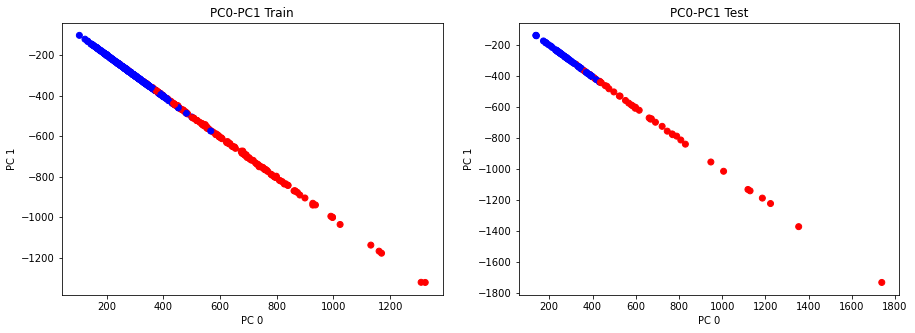

In [103]:
pc_0 = pipe['dimensionality_reduction'].transform(X_train)[:,0]
pc_1 = pipe['dimensionality_reduction'].transform(X_train)[:,1]
pc_2 = pipe['dimensionality_reduction'].transform(X_train)[:,2]

pc_0_test = pipe['dimensionality_reduction'].transform(X_test)[:,0]
pc_1_test = pipe['dimensionality_reduction'].transform(X_test)[:,1]
pc_2_test = pipe['dimensionality_reduction'].transform(X_test)[:,2]

color = {
    'M': 'red',
    'B': 'blue'
}
color_groups = [color[i] for i in y_train]
color_groups_test = [color[i] for i in y_test]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(pc_0, pc_1, c = color_groups)
ax[0].set_title('PC0-PC1 Train')
ax[0].set_xlabel('PC 0')
ax[0].set_ylabel('PC 1')

ax[1].scatter(pc_0_test, pc_1_test, c = color_groups_test)
ax[1].set_title('PC0-PC1 Test')
ax[1].set_xlabel('PC 0')
ax[1].set_ylabel('PC 1')

Text(0, 0.5, 'PC 2')

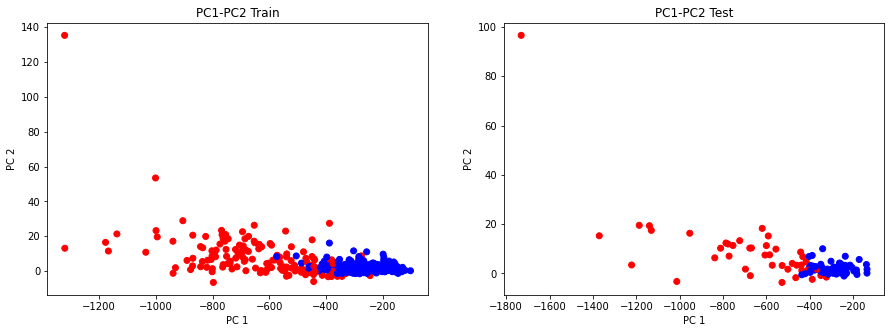

In [104]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(pc_1, pc_2, c = color_groups)
ax[0].set_title('PC1-PC2 Train')
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')

ax[1].scatter(pc_1_test, pc_2_test, c = color_groups_test)
ax[1].set_title('PC1-PC2 Test')
ax[1].set_xlabel('PC 1')
ax[1].set_ylabel('PC 2')

<h2 style="display: inline"> Optional - Clustering </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="Optional"></a> 

<div class="alert alert-success">
<h3> Exercise:</h3>
<ol>
    <li> Split the data in a training (80%) and test (20%) set
    <li> Classify the data with a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans">Kmeans</a> and test out some different n_cluster parameters. 
    <li> Visualize the predictions of the different models
<ol>
</div>

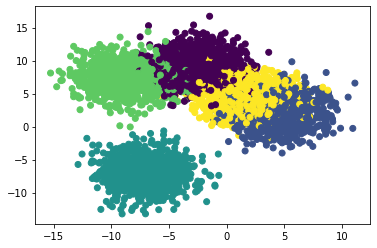

In [121]:
# Generate some toy data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=5000,
  centers=5,
  cluster_std=2,
  random_state=42
 )
plt.scatter(X[:,0], X[:,1], c = y)

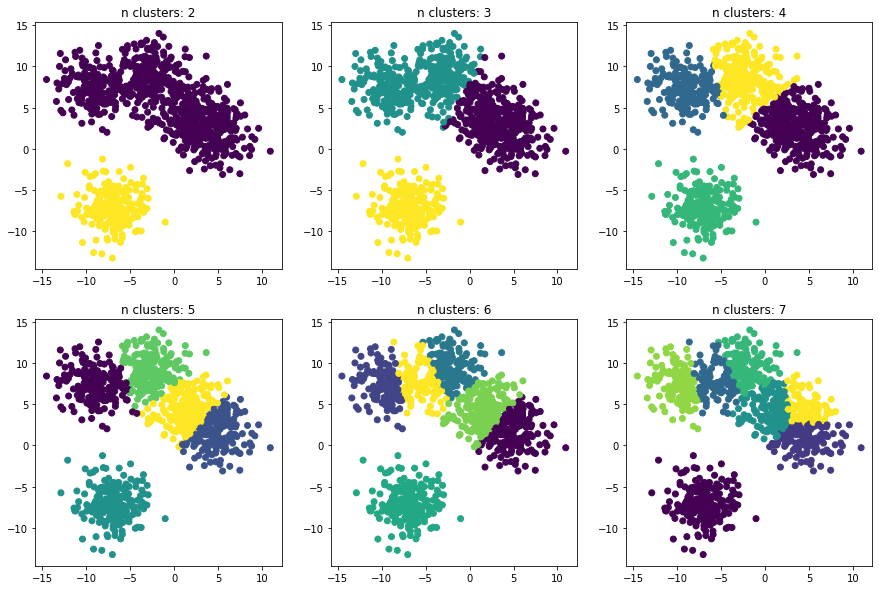

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


params_n_clusters = [2,3,4,5,6,7]
fig, axes = plt.subplots(2,3, figsize=(15,10))
coords = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]
for i in range(0,len(params_n_clusters)):
    clf = KMeans(n_clusters = params_n_clusters[i])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    ax = axes[coords[i][0], coords[i][1]]
    ax.scatter(X_test[:,0], X_test[:,1], c = preds)
    ax.set_title('n clusters: ' + str(params_n_clusters[i]) )
    
